### ЗАДАЧА ДЛЯ САМОСТОЯТЕЛЬНОГО ПРОЕКТА

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили [показатели ВВП](https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ghana_gdp.zip) Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [97]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA

from arch import arch_model

import pmdarima as pm

from matplotlib import pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
# загружаем даннын
url = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ghana_gdp.zip'
df = pd.read_csv(url, index_col='year', parse_dates=['year'])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [3]:
df.shape

(62, 1)

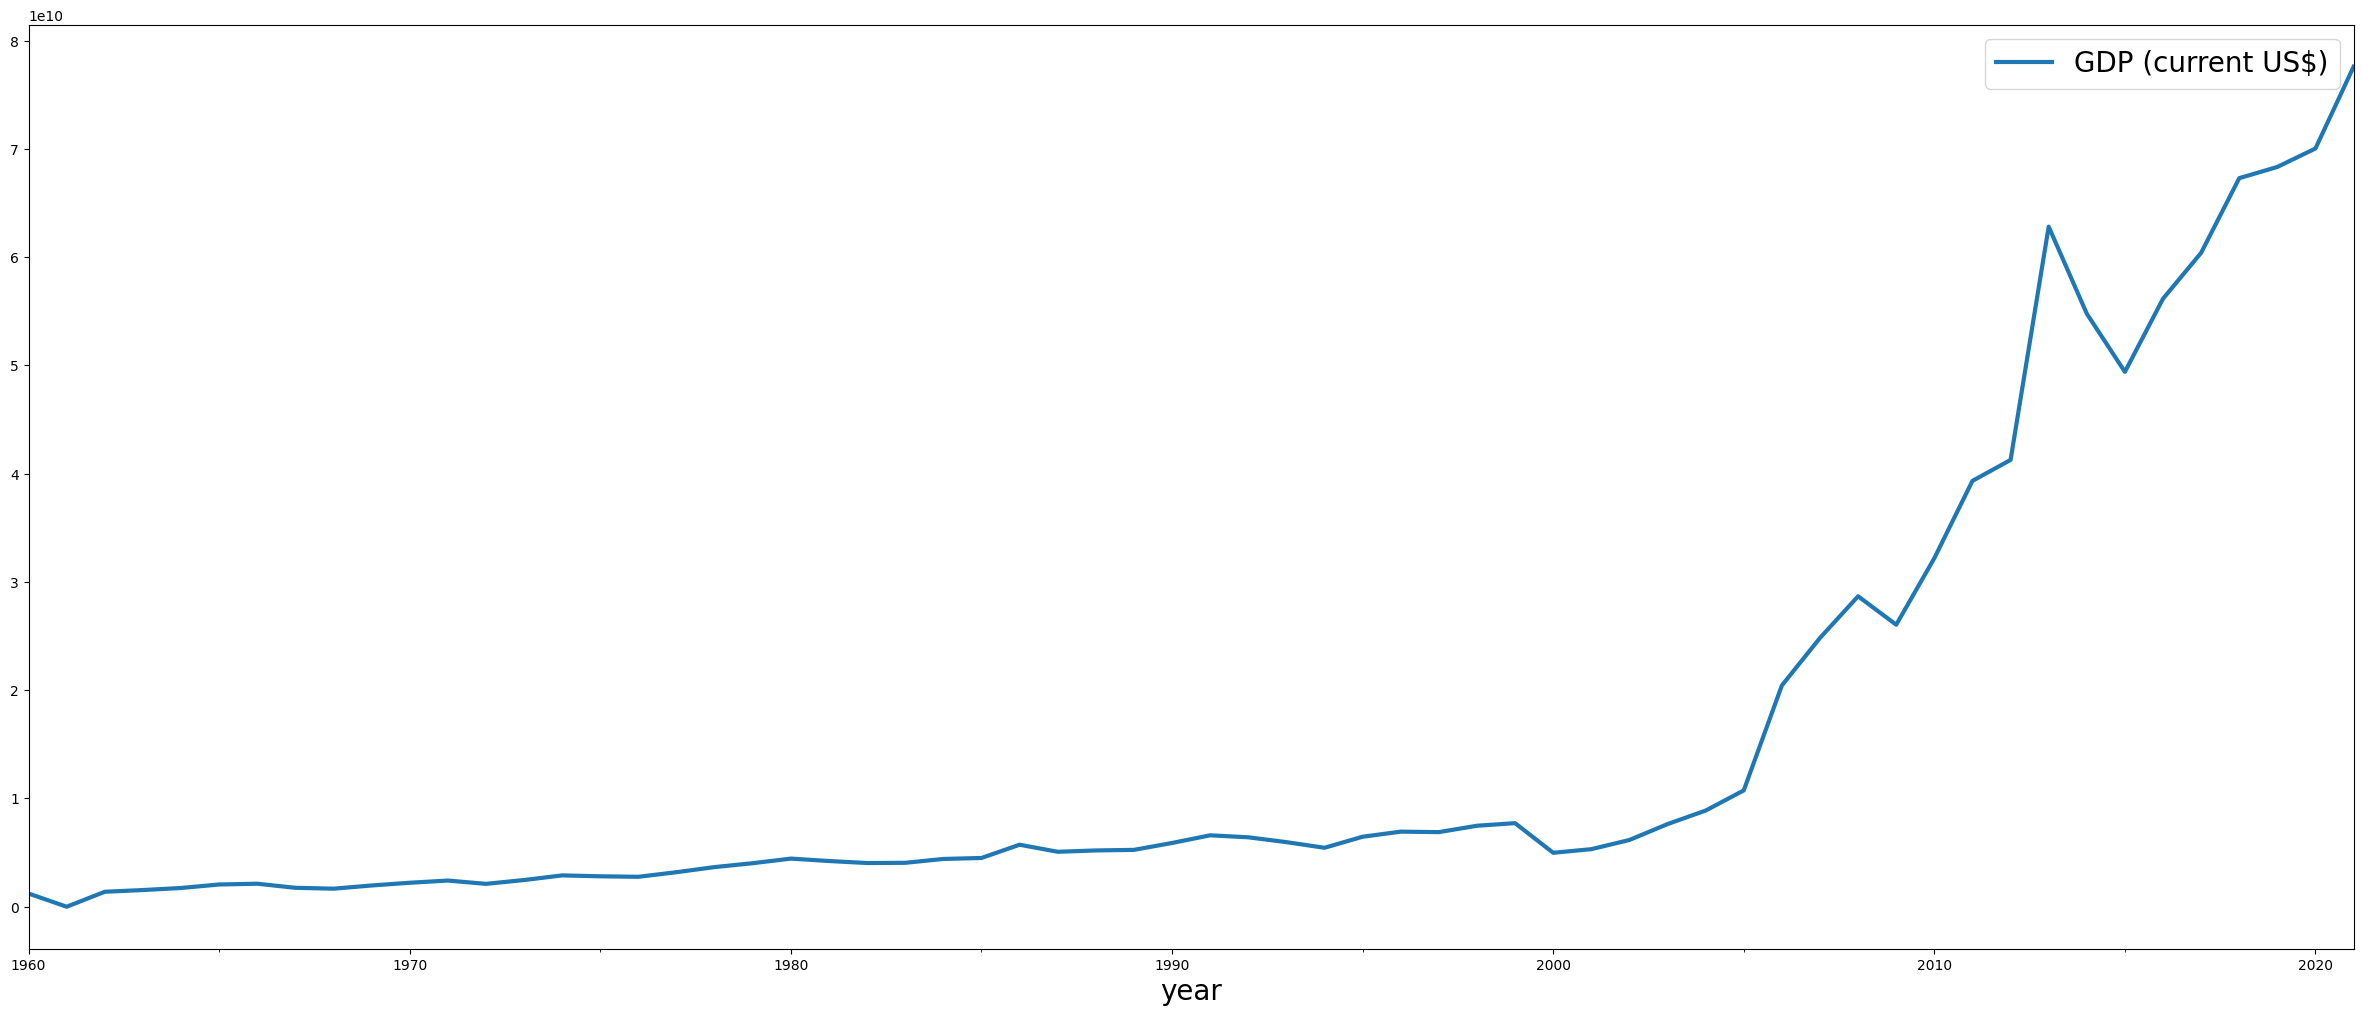

In [4]:
# посмотрим на график
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

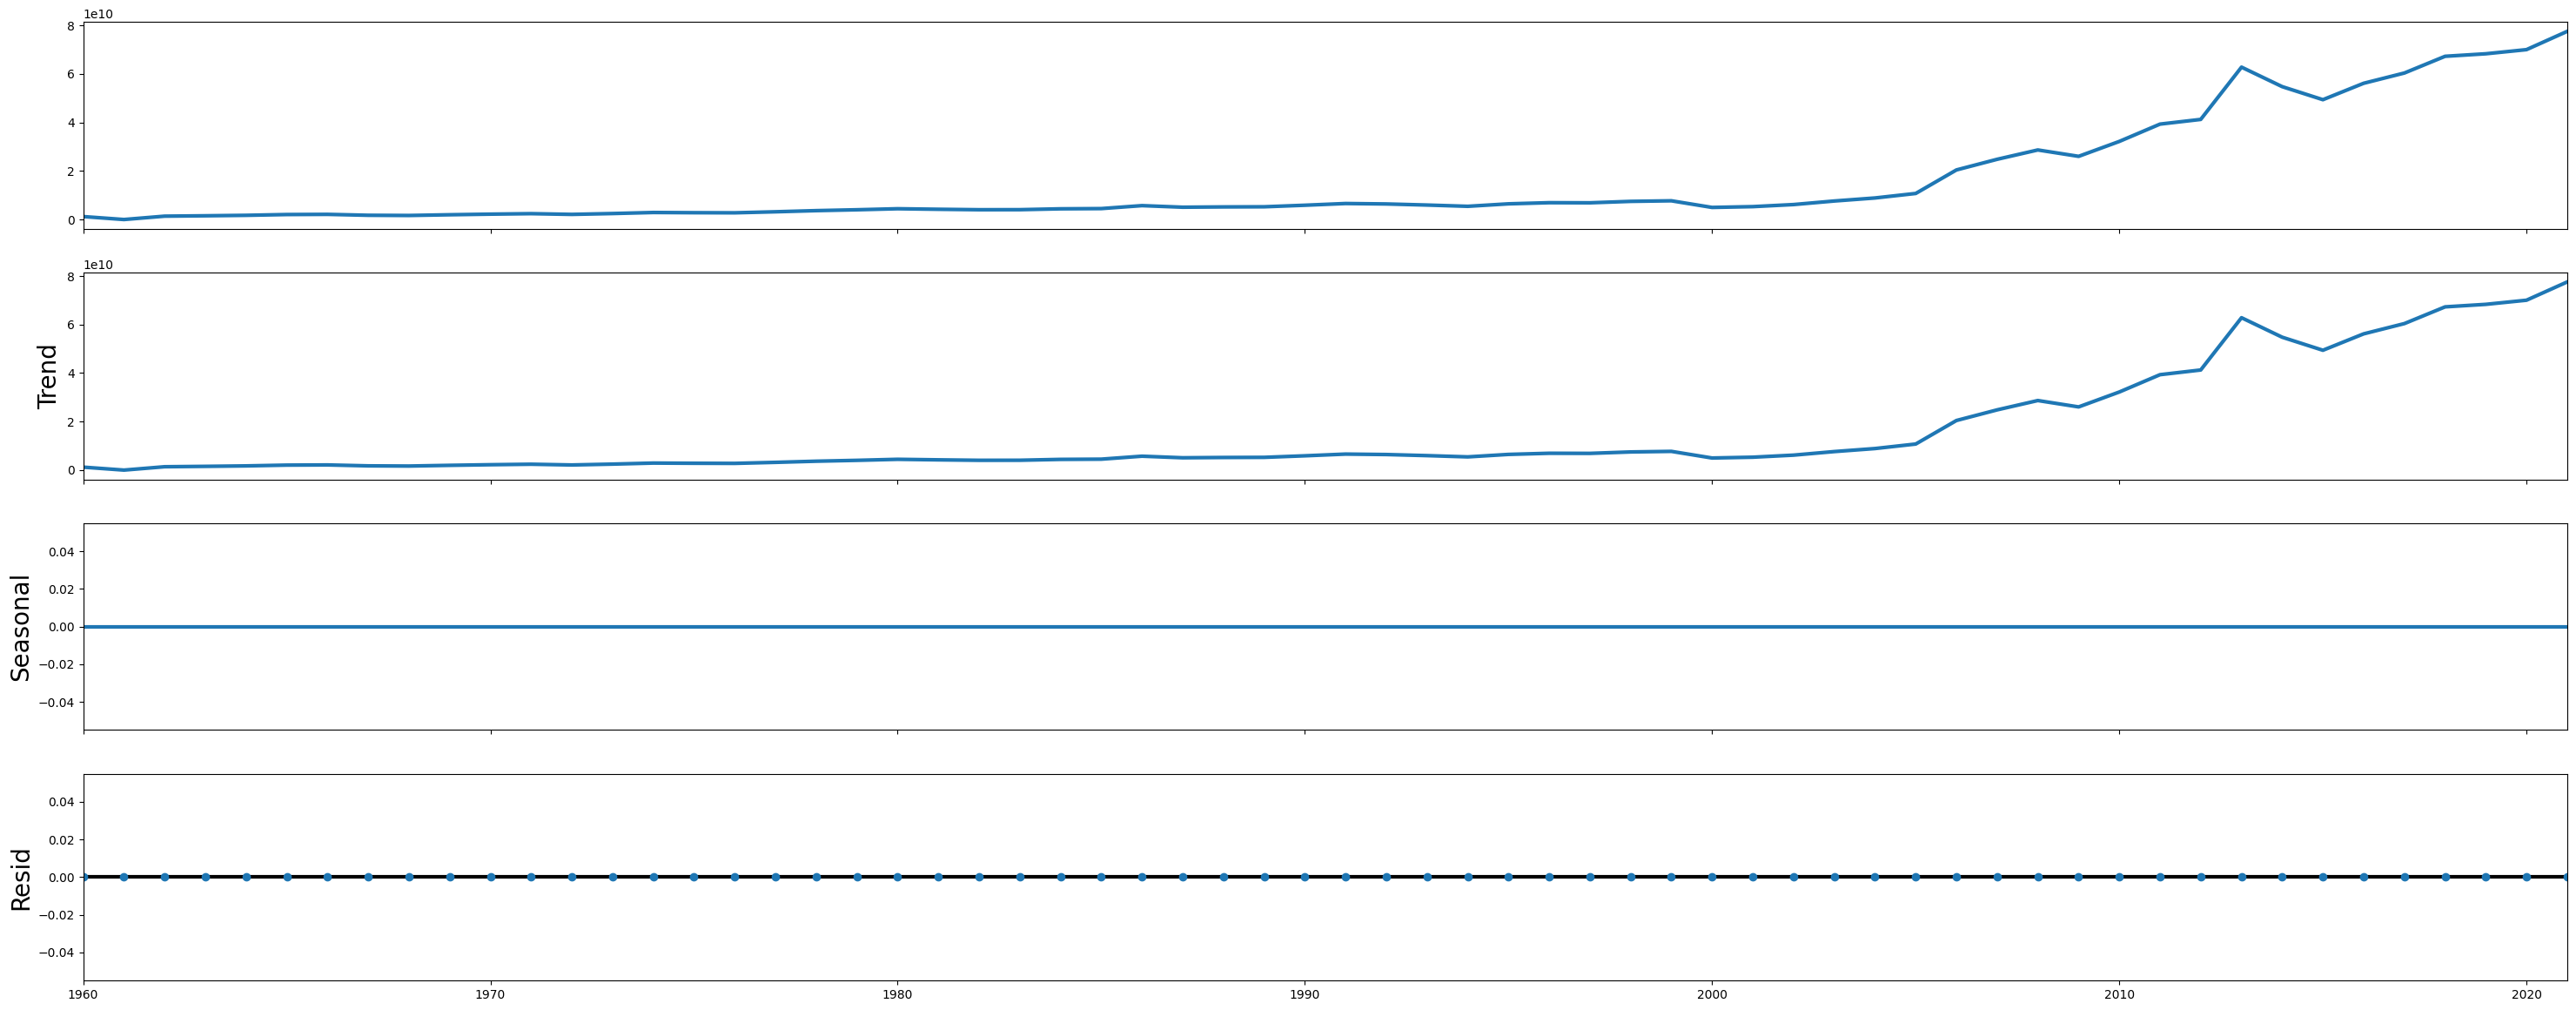

In [5]:
# проведем декомпозицию
decomposition = seasonal_decompose(df, model='additive') 
decomposition.plot()
plt.show()

До примерно 2005 года наблюдается незначительный рост ВВП, а после 2005 года "взрывной" рост. За 15 лет рост почти в 8 раз.  
Сезонности в графике не наблюдается.

In [6]:
# Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

# разделим выборку на тренировочную и тестовую
train_df = df.iloc[:df.shape[0]-3]
test_df = df.iloc[df.shape[0]-3:]
df.shape, train_df.shape, test_df.shape

((62, 1), (59, 1), (3, 1))

Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

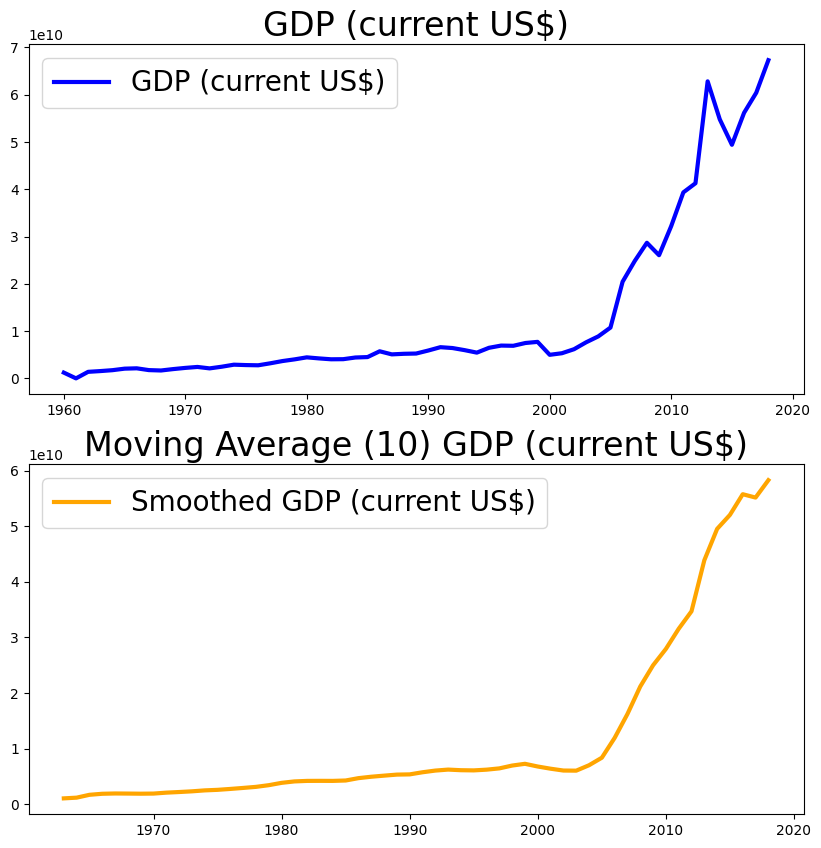

In [7]:
plt.rcParams["figure.figsize"] = 10, 10

fig, ax = plt.subplots(2, 1)

ax[0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[0].set_title("GDP (current US$)", size=24)
ax[0].legend()

ax[1].plot(
    train_df['GDP (current US$)'].rolling(window=4).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1].set_title("Moving Average (10) GDP (current US$)", size=24)
ax[1].legend();


Из графика видно наличие небольшого восходящего тренда с начала наблюдения и до 2005 года, а далее можно наблюдать сильный восходящий тренд.

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

In [8]:
# сделаем функцию для проверки стационарности
def test_adfuller(data):
    
    result = adfuller(data.values)
    
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")

    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if result[0] > result[4]['5%']: 
        print ('Ряд нестационарен')
    else:
        print ('Ряд стационарен')


In [9]:
test_adfuller(train_df)

ADF Statistic: 0.653
p-value: 0.989
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
Ряд нестационарен


Ряд нестационарен, применяем модель ARIMA

In [10]:
# Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым.
def diff_data(data):
    n = 0
    max_n = 5
    train_df_diff = data.copy()

    while n < max_n:
        n += 1
        train_df_diff = train_df_diff.diff().dropna()
        
        result = adfuller(train_df_diff.values)
        
        if not (result[0] > result[4]['5%']):
            test_adfuller(train_df_diff)
            print('Параметр d:', n)
            return train_df_diff
    if n == max_n:
        print('Достигнуто максимальное число итераций')

train_df_diff = diff_data(train_df)

ADF Statistic: -4.780
p-value: 0.000
Critical Values:
	1%: -3.575
	5%: -2.924
	10%: -2.600
Ряд стационарен
Параметр d: 3


In [11]:
# функция для постройки графиков
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 16, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=27)
    sgt.plot_pacf(series, ax=axes[1], lags=27, method="ywm")
    plt.show()

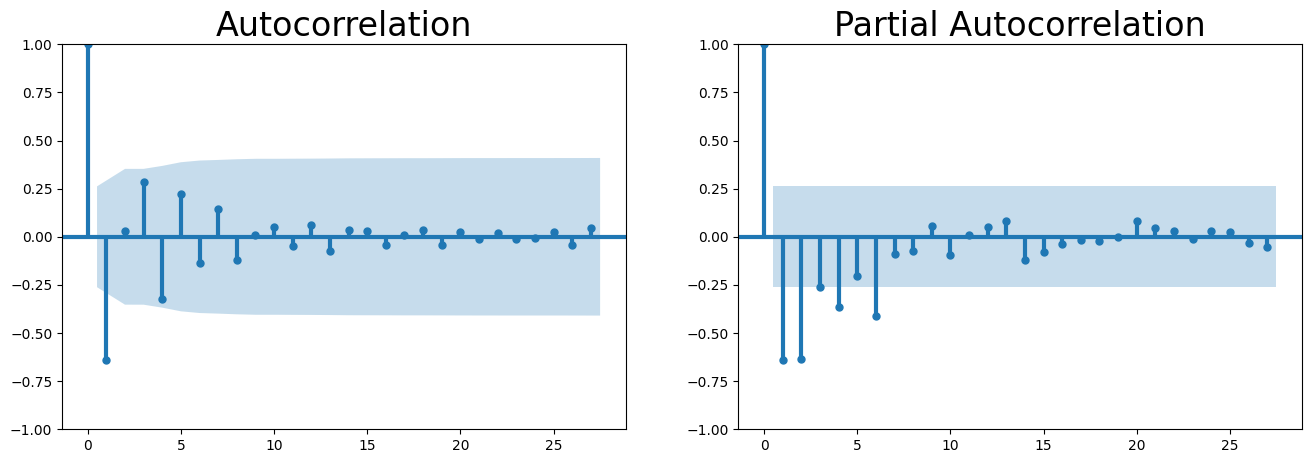

In [12]:
# строим графики
plot_acf_pacf(train_df_diff)

In [13]:
# Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки
p = 2
d = 3
q = 1
arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 07 Mar 2024   AIC                           2659.231
Time:                        23:36:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

In [14]:
# Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, 
# а также 95%-ый доверительный интервал для прогноза.
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

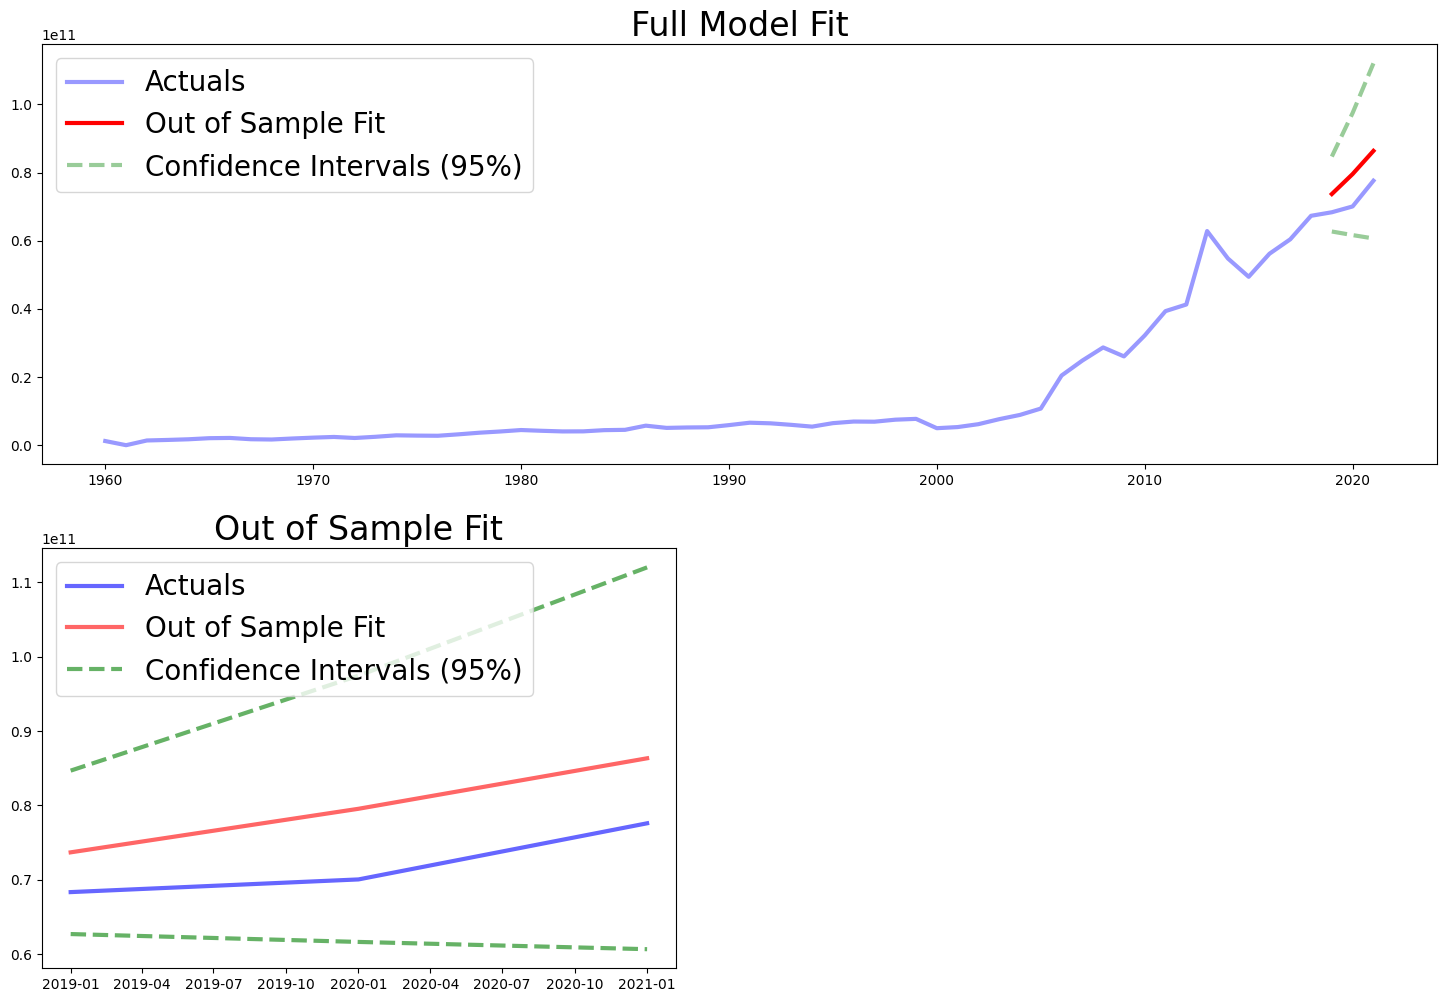

In [15]:
# строим графики
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [16]:
# подберите наилучшие параметры с помощью пакета pmdarima
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=6,
    max_q=4,
    seasonal=False,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.05 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.07 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.10 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.05 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.158 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Thu, 07 Mar 2024   AIC                           2659.231
Time:                        23:37:01   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

In [17]:
# Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, 
# а также 95%-ый доверительный интервал для прогноза.

pred_df = pd.DataFrame(index=df.index)
pred_df["model_preds"], conf_int = smodel.predict(n_periods=test_df.shape[0], return_conf_int=True, alpha=0.05)
pred_df["GDP (current US$)"] = df["GDP (current US$)"]

# Confidence level of 95%
pred_df.at[test_df.index, "model_preds_lower"] = conf_int[:, 0]
pred_df.at[test_df.index, "model_preds_upper"] = conf_int[:, 1]

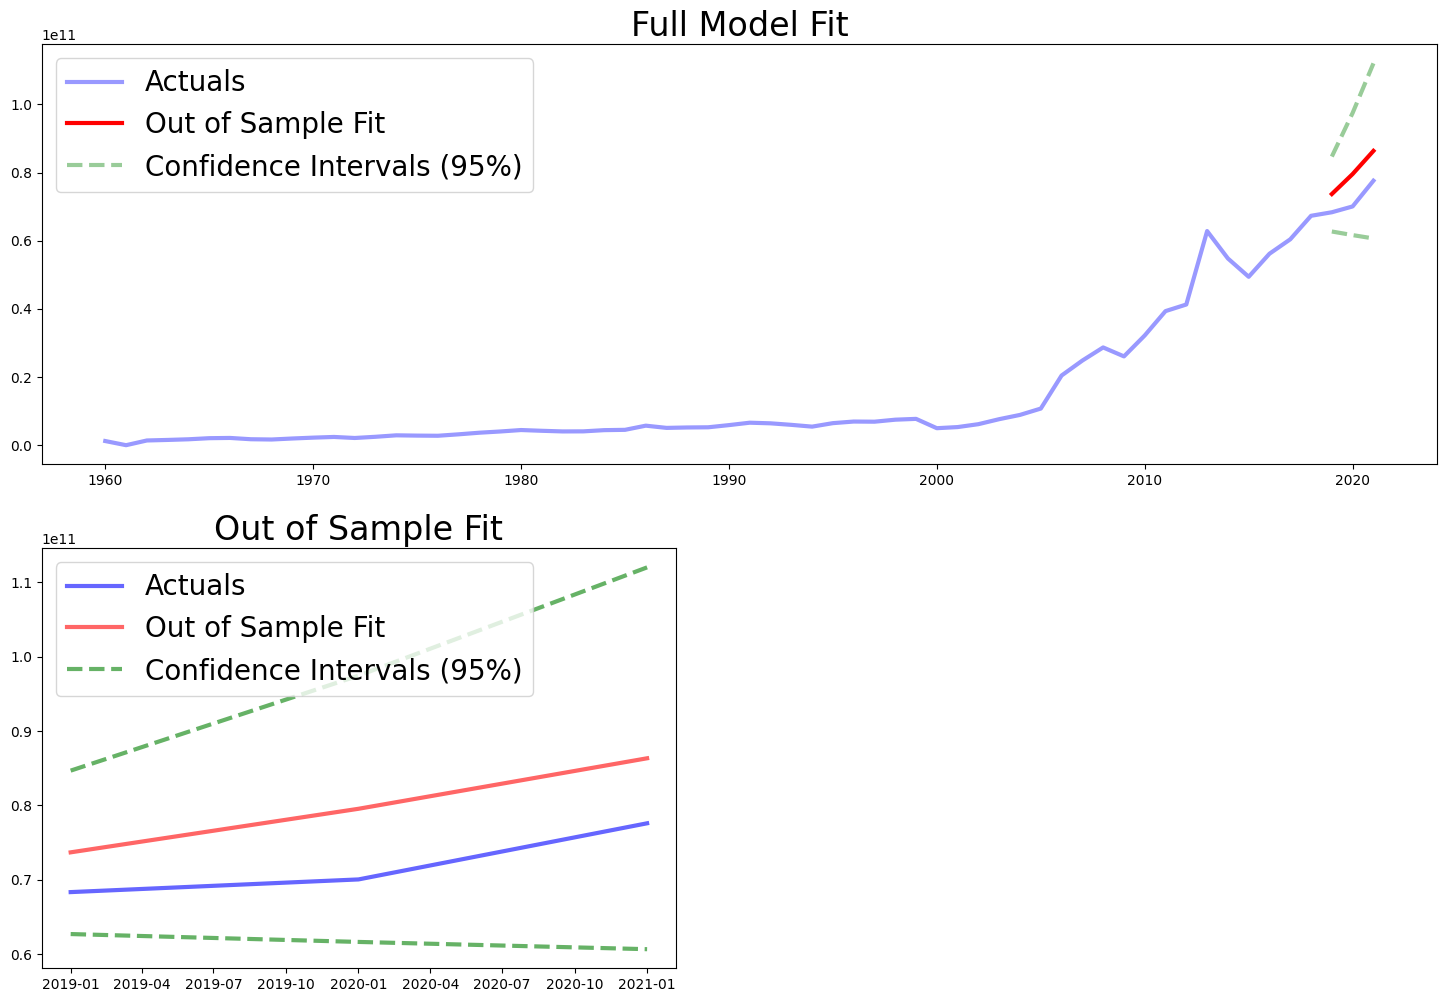

In [18]:
# строим графики
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Для разработки модели прогнозирования поведения временного ряда получены данные по ВВП Ганы.

С помощью теста Дики-Фуллера проверена стационарность временного ряда, определен параметр d и принято решение о выборе модели ARIMA.
По коррелограммам ACF и PACF, выбраны параметры p и q и построена модель.
Выполнено предсказание для отложенной тестовой выборки (последние три года) и построены графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

С помощью пакета pmdarima подобраны наилучшие параметры, выполнено предсказание и полученные результаты отражены графически.
Полученные в результате подбора параметры полностью совпали с параметрами выбранными по коррелограммам ACF и PACF.

По результатам визуализации, можно видеть, что наша модель достаточно точно предсказала значения ВВП Ганы.

## Downsampling / Upsampling / Интерполяция

In [19]:
# декомпозируем данные
df_up = df.asfreq(freq='d')
df_up.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1960-01-02,NaN
1960-01-03,NaN
1960-01-04,NaN
1960-01-05,NaN


In [20]:
df_up.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22282 entries, 1960-01-01 to 2021-01-01
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 348.2 KB


In [21]:
# Проверьте данные на наличие пропущенных значений
df_up.isna().sum()

GDP (current US$)    22220
dtype: int64

In [22]:
# Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN
mask = df_up['GDP (current US$)'] == 0
df_up[mask]

,GDP (current US$)
year,
1961-01-01,0.0


Нашли одно значение равное 0. Но в исходном датасете это значение такое же. Оставляем как есть.

In [23]:
# Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().
df_up = df_up['GDP (current US$)'].interpolate(method='linear')
# превратим обратно в датафрейм
df_up = pd.DataFrame(df_up, columns=['GDP (current US$)'])

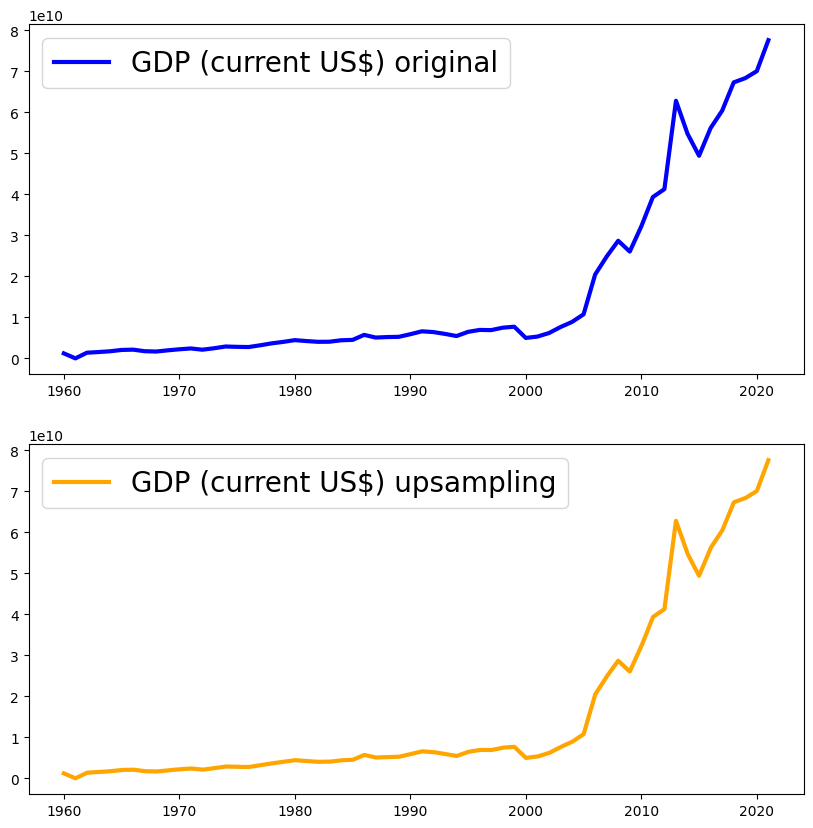

In [24]:
# посмотрим на график
plt.rcParams["figure.figsize"] = 10, 10

fig, ax = plt.subplots(2, 1)

ax[0].plot(df['GDP (current US$)'], 
           color="blue", 
           label="GDP (current US$) original")
ax[0].legend()

ax[1].plot(df_up['GDP (current US$)'],
           color="orange",
           label="GDP (current US$) upsampling")
ax[1].legend();


Ожидаемо, графики идентичны

In [25]:
# разделим выборку на тренировочную и тестовую
train_df = df_up.loc[:'2018-12-31']
test_df = df_up.loc['2019-01-01':]
df_up.shape, train_df.shape, test_df.shape

((22282, 1), (21550, 1), (732, 1))

In [26]:
# Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.
test_adfuller(train_df)


ADF Statistic: 0.817
p-value: 0.992
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд нестационарен


In [27]:
# дифферинцируем до получения стационарности
train_df_diff = diff_data(train_df)

ADF Statistic: -5.521
p-value: 0.000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд стационарен
Параметр d: 1


In [28]:
# воспользуемся pmdarima
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=10,
    max_q=10,
    seasonal=False,
    m=1,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1189417.193, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=757384.396, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2193824.530, Time=3.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=747869.858, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=759243.331, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=745771.356, Time=5.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1187736.058, Time=7.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=744606.204, Time=9.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1186351.312, Time=10.45 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=743803.657, Time=21.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1185193.903, Time=17.23 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=743191.651, Time=22.06 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1184215.107, Time=20.61 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=742695.813, Time=25.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                21550
Model:              SARIMAX(0, 1, 10)   Log Likelihood             -370638.481
Date:                Thu, 07 Mar 2024   AIC                         741300.962
Time:                        23:48:46   BIC                         741396.699
Sample:                    01-01-1960   HQIC                        741332.171
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.043e+06   2.53e-11    1.2e+17      0.000    3.04e+06    3.04e+06
ma.L1          0.1633      0.001    151.862      0.000       0.161       0.165
ma.L2          0.1589      0.001    202.769      0.000       0.157       0.160
ma.L3          0.1549      0.001    231.560      0.000       0.154       0.156
ma.L4          0.1515      0.001    216.375      0.000       0.150       0.153
ma.L5          0.1484      0.001    161.235      0.000       0.147       0.150
ma.L6          0.1459      0.002     96.200      0.000       0.143       0.149
ma.L7          0.1442      0.002     65.777      0.000       0.140       0.148
ma.L8          0.1431      0.003     42.860      0.000       0.137       0.150
ma.L9          0.1430      0.006     25.044      0.000       0.132       0.154
ma.L10         0.1439      0.004     34.685      0.000       0.136       0.152
sigma2      1.022e+14   1.56e-17   6.56e+30      0.000    1.02e+14    1.02e+14
===================================================================================
Ljung-Box (L1) (Q):               15920.11   Jarque-Bera (JB):         851894940.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                           -15.51
Prob(H) (two-sided):                  0.00   Kurtosis:                       976.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.5e+45. Standard errors may be unstable.
"""

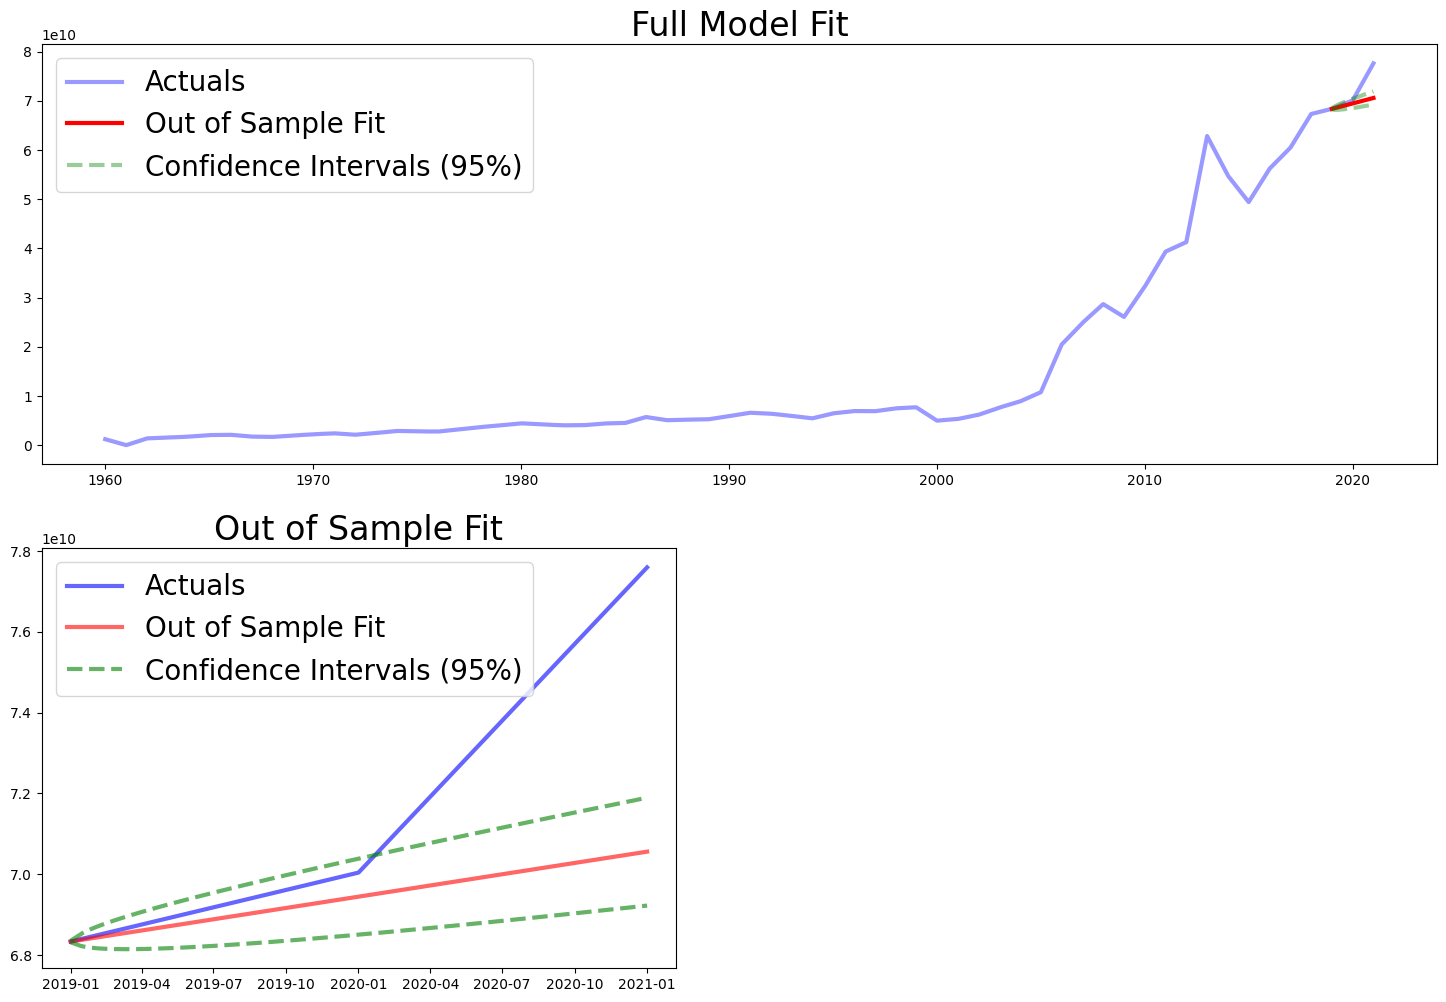

In [29]:
# посмотрим на графики

pred_df = pd.DataFrame(index=df_up.index)
pred_df["model_preds"], conf_int = smodel.predict(n_periods=test_df.shape[0], return_conf_int=True, alpha=0.05)
pred_df["GDP (current US$)"] = df_up["GDP (current US$)"]

# Confidence level of 95%
pred_df.at[test_df.index, "model_preds_lower"] = conf_int[:, 0]
pred_df.at[test_df.index, "model_preds_upper"] = conf_int[:, 1]

# строим графики
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

Критерий AIC, по сравнению с моделью постоенной на неинтерполированных данных увеличился, что говорит об ухудшении качества модели. Построенный график подтверждает этот вывод.

## Задание 8.3

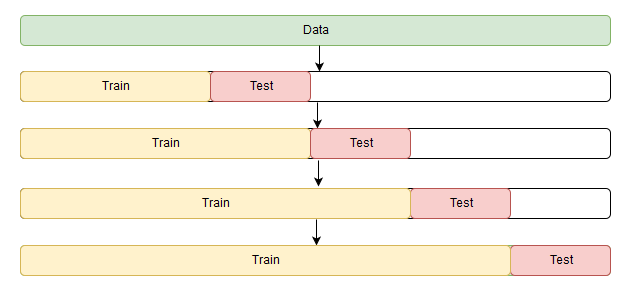

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) из ```sklearn.model_selection``` с параметрами ```n_splits=3``` и ```test_size=7``` (или ```max_train_size=df.sales.count()-7```). Наборы данных можно получить, вызвав метод ```split``` (временной ряд) у инициализированного *TimeSeriesSplit*.

Пример кода:
```Python
tscv = TimeSeriesSplit(...)
```
2. Выведите размеры полученных подвыборок:
```Python
train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
```
Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [32]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(df['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


Мы получили множественное разбиение.

## 9. Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика

### Посчитайте волатильность для вашего временного ряда.

In [114]:
df["GDP_vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()

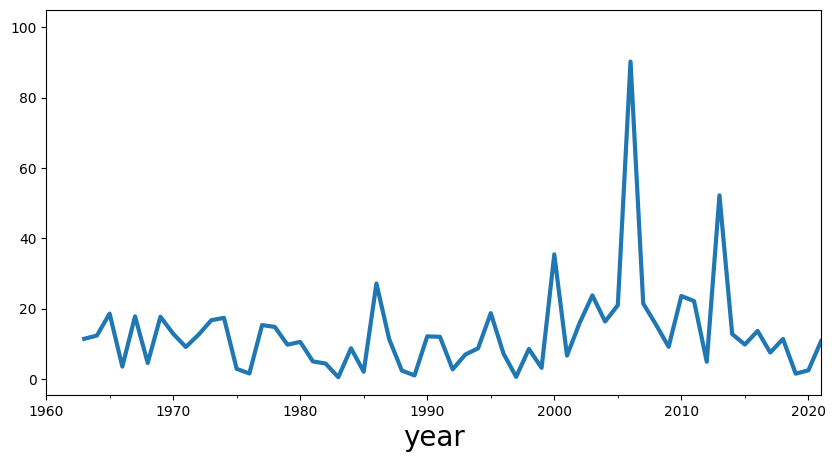

In [115]:
plt.rcParams["figure.figsize"] = 10, 5
df["GDP_vol"].plot()
plt.show()

### Используйте GARCH-модель для предсказания волатильности.

In [116]:
# разделим выборку на тренировочную и тестовую
df.replace(np.inf, 0, inplace=True)
train_df = df.iloc[:df.shape[0]-3]
test_df = df.iloc[df.shape[0]-3:]
df.shape, train_df.shape, test_df.shape


((62, 2), (59, 2), (3, 2))

In [117]:
# Проверяем полученный ряд на стационарность
test_adfuller(train_df["GDP_vol"][1:])

ADF Statistic: -9.701
p-value: 0.000
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
Ряд стационарен


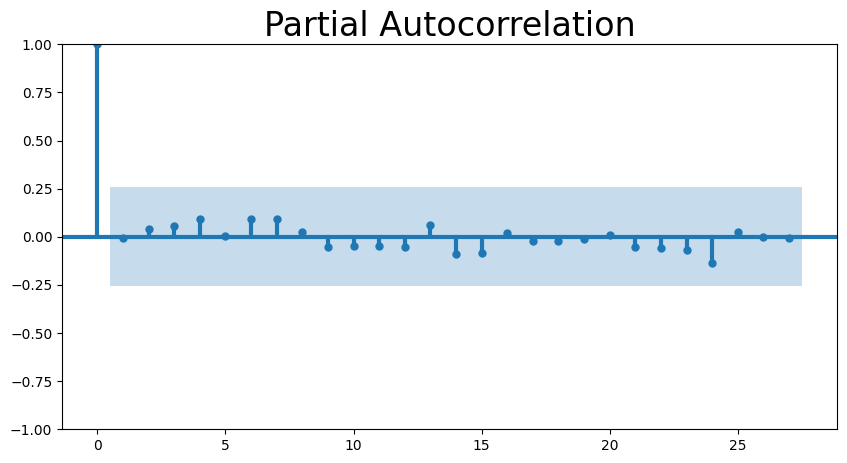

In [118]:
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df['GDP_vol'][1:], lags=27, method="ywm")
plt.show()

Не очень понятно. Попробую подобрать перебором.

In [119]:
garch_df = pd.DataFrame(df['GDP_vol'].loc[df.index])

garch_df.loc[train_df.index, 'GDP_vol'] = train_df['GDP_vol'][3:]

In [120]:
ls_results = []
for i in range(1, 8):
    model = arch_model(garch_df['GDP_vol'].dropna(), p=i, q=i)
    model_results = model.fit(last_obs=test_df.index[0], update_freq=5)
    ls_results.append([i, model_results.aic])

Iteration:      5,   Func. Count:     27,   Neg. LLF: 243.86675285677657
Iteration:     10,   Func. Count:     58,   Neg. LLF: 234.26719877468088
Iteration:     15,   Func. Count:     85,   Neg. LLF: 219.85841337687907
Optimization terminated successfully    (Exit mode 0)
            Current function value: 219.7718952377392
            Iterations: 19
            Function evaluations: 104
            Gradient evaluations: 19
Iteration:      5,   Func. Count:     39,   Neg. LLF: 221.5436750051606
Iteration:     10,   Func. Count:     74,   Neg. LLF: 219.93461957699694
Iteration:     15,   Func. Count:    109,   Neg. LLF: 219.88063114651493
Iteration:     20,   Func. Count:    144,   Neg. LLF: 219.77189579714317
Optimization terminated successfully    (Exit mode 0)
            Current function value: 219.77189512740955
            Iterations: 22
            Function evaluations: 151
            Gradient evaluations: 21
Iteration:      5,   Func. Count:     49,   Neg. LLF: 221.22070618720

In [90]:
ls_results

[[1, 447.5437904754784],
 [2, 451.5437902548191],
 [3, 455.93646718785607],
 [4, 443.40343898249836],
 [5, 464.3212258385727],
 [6, 443.76262003950336],
 [7, 447.02671684941754]]

In [121]:
# строим модель с лучшими параметрами
model = arch_model(garch_df['GDP_vol'].dropna(), p=4, q=4)
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     59,   Neg. LLF: 220.17770715392265
Iteration:     10,   Func. Count:    115,   Neg. LLF: 219.70871328795158
Iteration:     15,   Func. Count:    173,   Neg. LLF: 216.0982766222687
Iteration:     20,   Func. Count:    233,   Neg. LLF: 212.2257088330843
Iteration:     25,   Func. Count:    288,   Neg. LLF: 211.80527595221974
Iteration:     30,   Func. Count:    342,   Neg. LLF: 211.70171935083297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 211.70171949124918
            Iterations: 30
            Function evaluations: 342
            Gradient evaluations: 30


In [122]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -211.702
Distribution:                  Normal   AIC:                           443.403
Method:            Maximum Likelihood   BIC:                           463.657
                                        No. Observations:                   56
Date:                Sun, Mar 10 2024   Df Residuals:                       55
Time:                        22:48:50   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10.1025      0.965     10.473  1.155e-25 [  8.212, 11.993]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         19.9798     15.483      1.290      0.197      [-10.367, 50.326]
alpha[1]       0.0000  4.947e-03      0.000      1.000 [-9.696e-03,9.696e-03]
alpha[2]   1.2444e-12  3.814e-02  3.263e-11      1.000 [-7.475e-02,7.475e-02]
alpha[3]       0.7910      0.205      3.865  1.112e-04      [  0.390,  1.192]
alpha[4]   5.1683e-13      0.171  3.027e-12      1.000      [ -0.335,  0.335]
beta[1]    9.9861e-13      0.222  4.506e-12      1.000      [ -0.434,  0.434]
beta[2]    1.7403e-03  8.222e-03      0.212      0.832 [-1.437e-02,1.786e-02]
beta[3]        0.1535      0.209      0.735      0.463      [ -0.256,  0.563]
beta[4]        0.0537  6.493e-02      0.827      0.408   [-7.355e-02,  0.181]
=============================================================================

Covariance estimator: robust
"""

### Визуализируйте полученное предсказание вместе с фактическим значением.

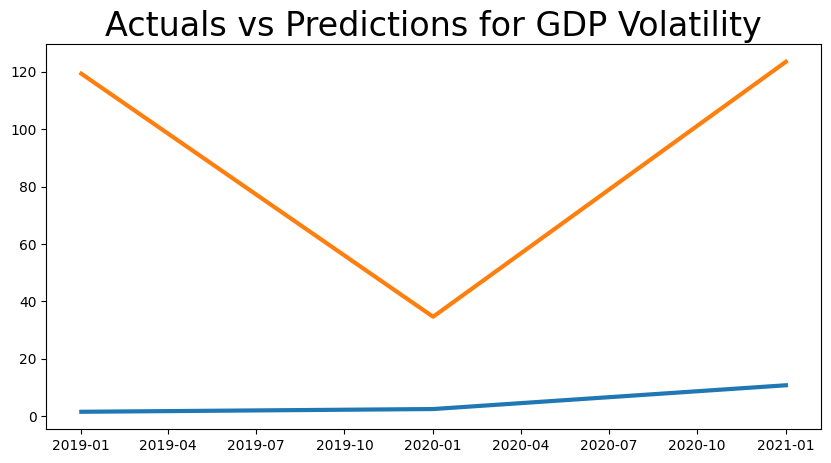

In [123]:

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[test_df.index]

plt.rcParams["figure.figsize"] = 10, 5
plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

In [126]:
# посчитаем среднеквадратичную ошибку
mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

9212.451341348762

Судя по графику модель не смогла предсказать значение дисперсии. Это может быть из-за незначительного количества данных в датасете и соответственно отсутствием подобных случаев в обучающей выборке.

### Используйте линейную регрессию для получения прогноза.

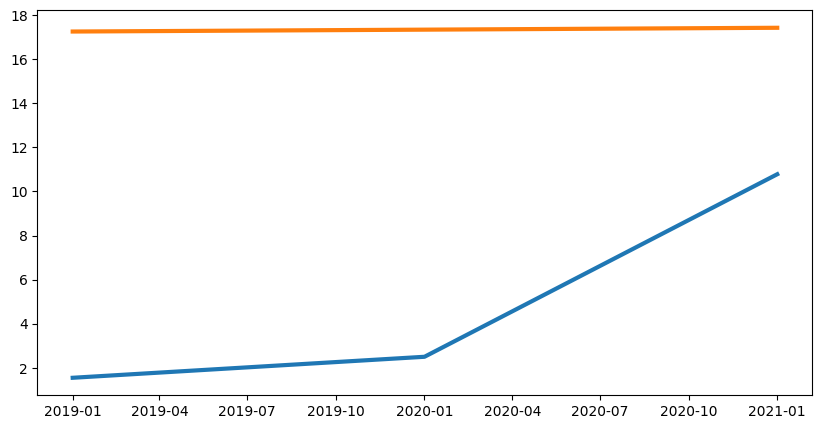

In [127]:
X_train = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Модель линейной регрессии так же не смогла справиться с предсказанием.